# Bell & Co. Customer Churn Prediction

## Introduction:

In this project, we are analyzing the type of customers who are leaving the Bell & Co. telephone company subscription. We also are trying to find potential indicators on why these customers are leaving. 

The goal of this project is to predict customers who will leave the company. For this we will use various models on given customer data. We will split the data into training and testing sets. We will fetch the training data into our model and test the efficiency of the model via training data set. At the end we will prescribe the tele-company on how to mitigate the customer churning.

In [162]:
library(corrplot)
library(cowplot)
library(ggplot2)
library(gridExtra)
library(randomForest)
library(caret)
library(party)
library(gmodels)

In [163]:
setwd("C:/GitBird Projects/BellCoCustomerChurn/Dataset")

In [164]:
customer_data<-read.csv("BellCo-Customer-Churn.csv", header = TRUE)

In [165]:
nrow(customer_data)

[1] 7043

## Decipher, Dedupe and Clean Data

In [166]:
str(customer_data)

'data.frame':	7043 obs. of  21 variables:
 $ customerID      : Factor w/ 7043 levels "0002-ORFBO","0003-MKNFE",..: 5376 3963 2565 5536 6512 6552 1003 4771 5605 4535 ...
 $ gender          : Factor w/ 2 levels "Female","Male": 1 2 2 2 1 1 2 1 1 2 ...
 $ SeniorCitizen   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Partner         : Factor w/ 2 levels "No","Yes": 2 1 1 1 1 1 1 1 2 1 ...
 $ Dependents      : Factor w/ 2 levels "No","Yes": 1 1 1 1 1 1 2 1 1 2 ...
 $ tenure          : int  1 34 2 45 2 8 22 10 28 62 ...
 $ PhoneService    : Factor w/ 2 levels "No","Yes": 1 2 2 1 2 2 2 1 2 2 ...
 $ MultipleLines   : Factor w/ 3 levels "No","No phone service",..: 2 1 1 2 1 3 3 2 3 1 ...
 $ InternetService : Factor w/ 3 levels "DSL","Fiber optic",..: 1 1 1 1 2 2 2 1 2 1 ...
 $ OnlineSecurity  : Factor w/ 3 levels "No","No internet service",..: 1 3 3 3 1 1 1 3 1 3 ...
 $ OnlineBackup    : Factor w/ 3 levels "No","No internet service",..: 3 1 3 1 1 1 3 1 1 3 ...
 $ DeviceProtection: Factor w/ 3 levels "No","

In [167]:
head(customer_data)

customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.50,Yes


‘Churn’ is our target variable. It is using binomial categorical values i.e. ‘Yes’ or ‘No’. It tells us if the customer left the company or not.

‘‘TotalCharges’ and ‘MonthlyCharges’ are numerical variables. ‘TotalCharges’ has few missing entries which can be substituted with NA for visibility, or with mean value But I chose to delete whole rows where data are missing because there were not many missing entries. 

In [168]:
#Find Missing entries and replace with NAs
customer_data[customer_data == "?"] <- NA

In [169]:
colnames(customer_data)[ apply(customer_data, 2, anyNA)]

[1] "TotalCharges"

In [170]:
nrow(customer_data[is.na(customer_data$TotalCharges),])

[1] 11

In [171]:
#Remove NA rows
customer_data <- customer_data[!(is.na(customer_data$TotalCharges)),]
nrow(customer_data)

[1] 7032

‘Senior Citizen’ is an independent predictor variable which takes in binomial numerical variable 0 of ‘No’ and 1 for ‘Yes’. This data can be changed into binomial categorial variable by replacing 0 and 1s with No and Yes and converting the variable into factor. 

In [172]:
#Changing SeniorCitizen to categorical data 
customer_data[customer_data$SeniorCitizen == 0,]$SeniorCitizen <- "No"
customer_data[customer_data$SeniorCitizen == 1,]$SeniorCitizen <- "Yes"
customer_data$SeniorCitizen <- as.factor(customer_data$SeniorCitizen)

Binomial categorical values take: ‘Yes’ or ‘No’. There are several other categorical variables. Some of the categorial data values are labeled different but basically means the same – e.g. “No Phone Service” is same as “No”. Hence, we dedupe the provided data.

In [173]:
#Some fields have more than Just Yes and No.
#Get Unique Colnames where customer data has No phone service
unique(colnames(customer_data)[which(customer_data == "No phone service", arr.ind=TRUE)[,2]])

[1] "MultipleLines"

In [117]:
#Substitute No Phone Service to No
customer_data[customer_data$MultipleLines == "No phone service",]$MultipleLines <- "No"

Similarly, substituted "No Internet Service" to "No" values for other variables

In [118]:
#Get Unique Colnames where customer data has No internet service
unique(colnames(customer_data)[which(customer_data == "No internet service", arr.ind=TRUE)[,2]])

[1] "OnlineSecurity"   "OnlineBackup"     "DeviceProtection" "TechSupport"     
[5] "StreamingTV"      "StreamingMovies"

In [176]:
#Substitute No Internet Service to No
customer_data[customer_data$OnlineSecurity == "No internet service",]$OnlineSecurity <- "No"
customer_data[customer_data$OnlineBackup == "No internet service",]$OnlineBackup <- "No"
customer_data[customer_data$DeviceProtection == "No internet service",]$DeviceProtection <- "No"
customer_data[customer_data$TechSupport == "No internet service",]$TechSupport <- "No"
customer_data[customer_data$StreamingTV == "No internet service",]$StreamingTV <- "No"
customer_data[customer_data$StreamingMovies == "No internet service",]$StreamingMovies <- "No"

Checked and removed duplicate customer info (But there were no duplicates in this case)

In [174]:
#Dedupe
deduped_cus_data<-customer_data[!duplicated(customer_data["customerID"]),]

In [175]:
nrow(deduped_cus_data) 
# the number of rows are same so nothing to dedupe

[1] 7032

Grouped ages and translated ‘Tenure’ column to  ‘TenureCategories’ . Removed ‘Tenure’  column.

In [177]:
# create  tenure categories 
attach(customer_data)
customer_data$tenure_category[customer_data$tenure > 60] <- "Over 5 years "
customer_data$tenure_category[customer_data$tenure > 48 & customer_data$tenure <= 60] <- "4-5 years"
customer_data$tenure_category[customer_data$tenure > 24 & customer_data$tenure <= 48] <- "2-4 years"
customer_data$tenure_category[customer_data$tenure > 12 & customer_data$tenure <= 24] <- "1-2 years"
customer_data$tenure_category[customer_data$tenure<= 12] <- "Under 1 year"
detach(customer_data)
customer_data$tenure_category <- as.factor(customer_data$tenure_category)

In [178]:
#Remove columns that won't be used for modeling
customer_data$customerID <-NULL
customer_data$tenure <- NULL

## Correlated data

Correlation function helps to identify if there is strong or negative relationship between numeric variables. In our case, we have _TotalCharges and MonthlyCharges_. _TotalCharges_ essentially is derived from _MonthlyCharges_. But just for sake of it, we also see that there is strong relation between these two variables. Correlation provides positive or negative relation measured between -1 to 1
corrplot. gives heat map of relation between two numerical variables. It is better than a line or bar plot as heat map gives intensity of relationships with shades which cannot be given by other methods. 


In [179]:
# Find Correlation and plot between numeric field
colnames(customer_data[sapply(customer_data,is.numeric)])
numeric_correlation<-cor(customer_data[,sapply(customer_data, is.numeric)])
numeric_correlation

[1] "MonthlyCharges" "TotalCharges"

,MonthlyCharges,TotalCharges
MonthlyCharges,1.0000000,0.6510648
TotalCharges,0.6510648,1.0000000


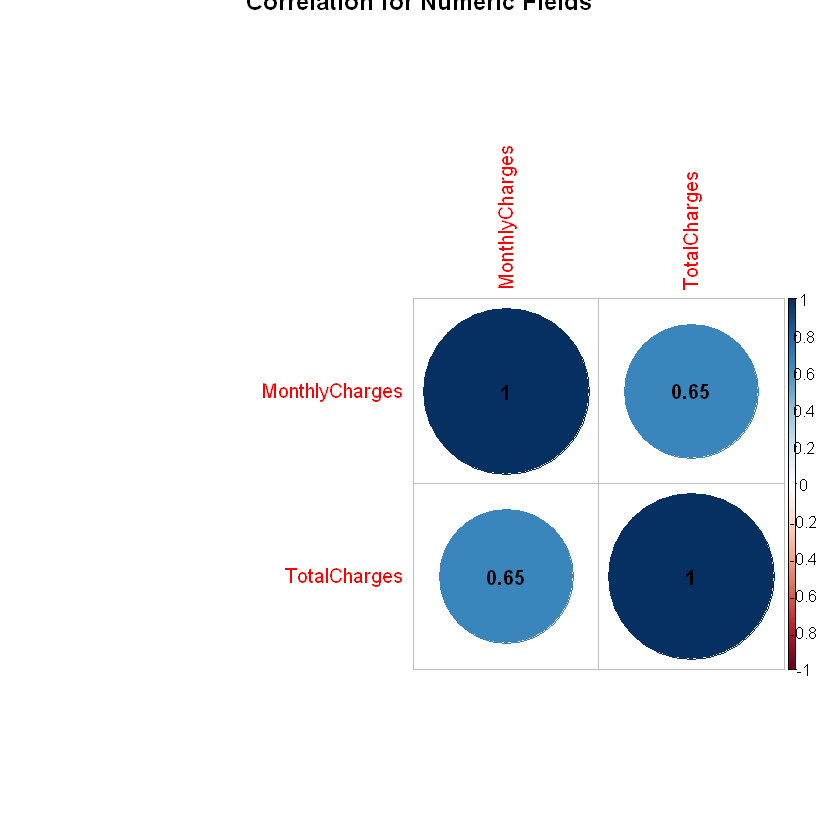

In [182]:
corrplot(numeric_correlation, main="Correlation for Numeric Fields", method="circle", addCoef.col = "black")

There were three numeric variables to start out with. But after _SeniorCitizen_ was changed into categorical factor variable, we find numeric relation between remaining variables: _MonthlyCharges_ and _TotalCharges_. We see that correlation coefficient between them is 0.65 which is gearing towards high correlation. Hence, we drop one of the variables. Since it is easier to compare monthly charges of customers who have varying tenures, we drop _TotalCharges_.

In [183]:
#MonthlyCharges is almost highly correlated with TotalCharges.
#Removing TotalCharges
customer_data$TotalCharges<-NULL

In [184]:
#Saving Clean Data
write.csv(customer_data,"C:/GitBird Projects/BellCoCustomerChurn/Dataset/customer_data_clean.csv")

## Data Analysis

### Distribution of Categorical Variables

We also would like to see count and percent count of each predictor variables to see Churn ratio between different values in a variable. 

In [128]:
#Plotting Categorical variables
colnames(customer_data[sapply(customer_data,is.factor)])

[1] "gender"           "SeniorCitizen"    "Partner"          "Dependents"      
 [5] "PhoneService"     "MultipleLines"    "InternetService"  "OnlineSecurity"  
 [9] "OnlineBackup"     "DeviceProtection" "TechSupport"      "StreamingTV"     
[13] "StreamingMovies"  "Contract"         "PaperlessBilling" "PaymentMethod"   
[17] "Churn"            "tenure_category"


 
   Cell Contents
|-------------------------|
|                       N |
|           N / Row Total |
|           N / Col Total |
|         N / Table Total |
|-------------------------|

 
Total Observations in Table:  7032 

 
                     | customer_data$SeniorCitizen 
customer_data$gender |        No |       Yes | Row Total | 
---------------------|-----------|-----------|-----------|
              Female |      2915 |       568 |      3483 | 
                     |     0.837 |     0.163 |     0.495 | 
                     |     0.495 |     0.497 |           | 
                     |     0.415 |     0.081 |           | 
---------------------|-----------|-----------|-----------|
                Male |      2975 |       574 |      3549 | 
                     |     0.838 |     0.162 |     0.505 | 
                     |     0.505 |     0.503 |           | 
                     |     0.423 |     0.082 |           | 
---------------------|-----------|-----------|-----------|
 

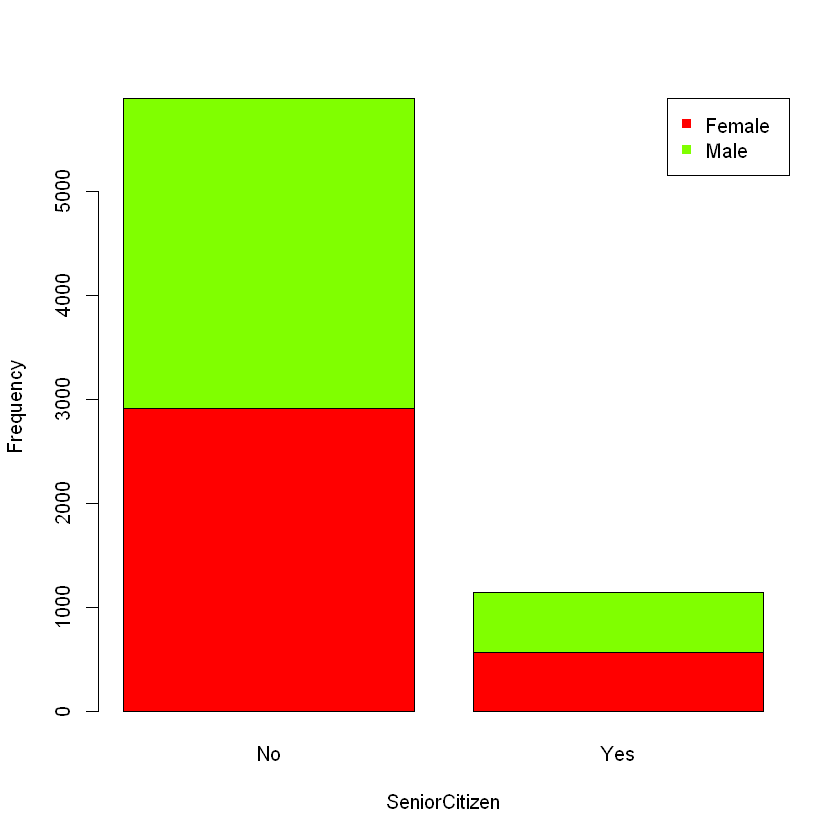

In [129]:
#Bar plot frequency between Senior Citizen along with gender
joint <- CrossTable(customer_data$gender, customer_data$SeniorCitizen, prop.chisq = FALSE)
barplot(joint$t, beside = FALSE, col=rainbow(4), ylab="Frequency", xlab="SeniorCitizen")
legend('topright', c('Female', 'Male'), pch=15, col = rainbow(4))

#### Distribution of variables using univariate statistics 

Making sure Churning comes from each categories. If only males have Churning then we should remove all females

In [189]:
xtabs(~ Churn + gender, data=customer_data)

     gender
Churn Female Male
  No    2544 2619
  Yes    939  930

Churn and Not Churn is represented by both Males and Female.

We could create similar table for all other variables. But we can also plot bar chart instead.

In [191]:
#Preparing bar chart for viewing distribution of variables(all boolean and categorical variables that we are using to predict Churning)
p2<-ggplot(customer_data, aes(x = SeniorCitizen, y = ((..count..)/sum(..count..))*100)) + geom_bar()+geom_text(stat='count', aes(label= round(((..count..)/sum(..count..))*100, 2)), angle=45, size=4)+ylab("Percentage");
p3<-ggplot(customer_data, aes(x = Partner, y = ((..count..)/sum(..count..))*100)) + geom_bar()+geom_text(stat='count', aes(label= round(((..count..)/sum(..count..))*100, 2)), angle=45, size=4)+ylab("Percentage");
p4<-ggplot(customer_data, aes(x = Dependents, y = ((..count..)/sum(..count..))*100)) + geom_bar()+geom_text(stat='count', aes(label= round(((..count..)/sum(..count..))*100, 2)), angle=45, size=4)+ylab("Percentage");
p5<-ggplot(customer_data, aes(x = tenure_category, y = ((..count..)/sum(..count..))*100)) + geom_bar()+geom_text(stat='count', aes(label= round(((..count..)/sum(..count..))*100, 2)), angle=45, size=4)+ylab("Percentage");
p6<-ggplot(customer_data, aes(x = PhoneService, y = ((..count..)/sum(..count..))*100)) + geom_bar()+geom_text(stat='count', aes(label= round(((..count..)/sum(..count..))*100, 2)), angle=45, size=4)+ylab("Percentage");
p7<-ggplot(customer_data, aes(x = MultipleLines, y = ((..count..)/sum(..count..))*100)) + geom_bar()+geom_text(stat='count', aes(label= round(((..count..)/sum(..count..))*100, 2)), angle=45, size=4)+ylab("Percentage");
p8<-ggplot(customer_data, aes(x = InternetService, y = ((..count..)/sum(..count..))*100)) + geom_bar()+geom_text(stat='count', aes(label= round(((..count..)/sum(..count..))*100, 2)), angle=45, size=4)+ylab("Percentage");
p9<-ggplot(customer_data, aes(x = OnlineSecurity, y = ((..count..)/sum(..count..))*100)) + geom_bar()+geom_text(stat='count', aes(label= round(((..count..)/sum(..count..))*100, 2)), angle=45, size=4)+ylab("Percentage");
p10<-ggplot(customer_data, aes(x = OnlineBackup, y = ((..count..)/sum(..count..))*100)) + geom_bar()+geom_text(stat='count', aes(label= round(((..count..)/sum(..count..))*100, 2)), angle=45, size=4)+ylab("Percentage");
p11<-ggplot(customer_data, aes(x = DeviceProtection, y = ((..count..)/sum(..count..))*100)) + geom_bar()+geom_text(stat='count', aes(label= round(((..count..)/sum(..count..))*100, 2)), angle=45, size=4)+ylab("Percentage");
p12<-ggplot(customer_data, aes(x = TechSupport, y = ((..count..)/sum(..count..))*100)) + geom_bar()+geom_text(stat='count', aes(label= round(((..count..)/sum(..count..))*100, 2)), angle=45, size=4)+ylab("Percentage");
p13<-ggplot(customer_data, aes(x = StreamingTV, y = ((..count..)/sum(..count..))*100)) + geom_bar()+geom_text(stat='count', aes(label= round(((..count..)/sum(..count..))*100, 2)), angle=45, size=4)+ylab("Percentage");
p14<-ggplot(customer_data, aes(x = StreamingMovies, y = ((..count..)/sum(..count..))*100)) + geom_bar()+geom_text(stat='count', aes(label= round(((..count..)/sum(..count..))*100, 2)), angle=45, size=4)+ylab("Percentage");
p15<-ggplot(customer_data, aes(x = OnlineBackup, y = ((..count..)/sum(..count..))*100)) + geom_bar()+geom_text(stat='count', aes(label= round(((..count..)/sum(..count..))*100, 2)), angle=45, size=4)+ylab("Percentage");
p16<- ggplot(customer_data, aes(x = PaperlessBilling, y = ((..count..)/sum(..count..))*100)) + geom_bar()+geom_text(stat='count', aes(label= round(((..count..)/sum(..count..))*100, 2)), angle=45, size=4)+ylab("Percentage");

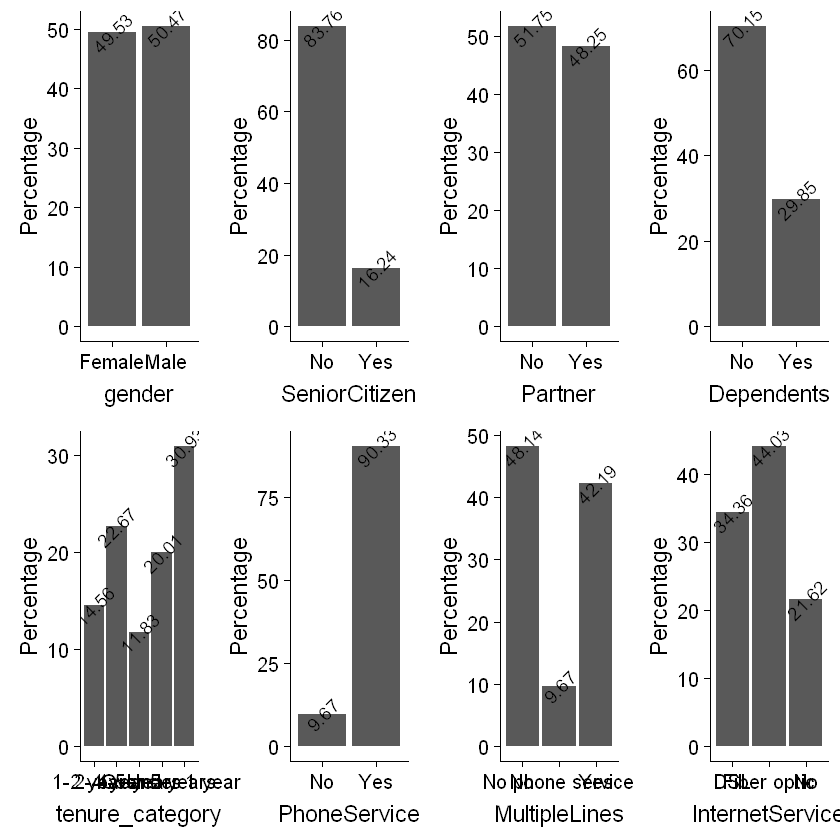

In [193]:
grid.arrange(p1, p2, p3, p4,p5, p6, p7, p8, ncol=4)

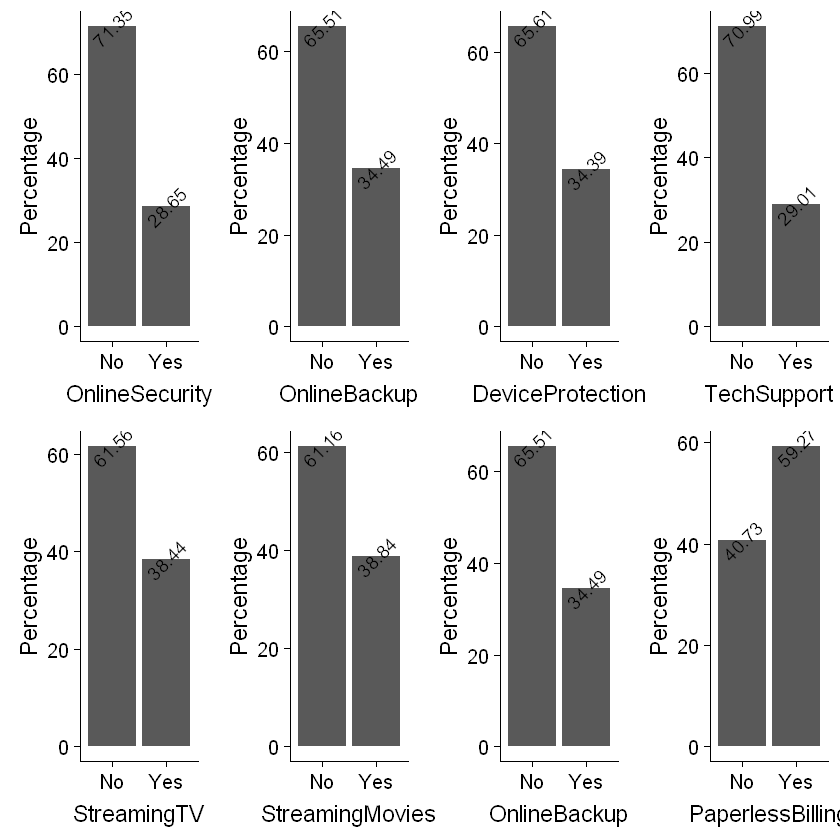

In [134]:
grid.arrange(p9,p10,p11, p12,p13,p14,p15,p16,ncol=4)

## Model Choice
### Logistic Regression

I have chosen logistic regression for predictive modeling while decision tree and random forest for classification. Linear regression was not used because it will only give linear relationship of an outcome variable with other independent variables and not display probability of outcome(churning).

Logistic regression is appropriate because _Churn_,the variable we also want to predict, which is the outcome variable is binary (yes or no). The model is helpful in calculating probability of significance for each of the variables affecting the _Churn_. Logistic regression is helpful to calculate churning predictability of each customer by getting probability or log(odds).

For modeling and predicting purposes, multiple logistic regression was used because there is one target variable _Churn_ and multiple independent variables. We will pass all the predictor variables with  the target variable _Churn_ into logistic model. We will summarize the significance probability (p value) for each of the variable in respect to churning. 

We determined important variables by looking at their significance(p-value) and coefficient intercept value in the logistic regression summary. If the variables were not significant in determining the Churn predictability, they were removed from the model. Finally, we created new logistic model to determine predictability of the churn.

In [135]:
#Starting out with Simple logistic regression first
logistic_Simple <- glm(Churn ~ SeniorCitizen, data=customer_data, family = binomial)
summary(logistic_Simple)


Call:
glm(formula = Churn ~ SeniorCitizen, family = binomial, data = customer_data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.0385  -0.7346  -0.7346   1.3230   1.6981  

Coefficients:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -1.17195    0.03066  -38.22   <2e-16 ***
SeniorCitizenYes  0.83608    0.06740   12.40   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 8143.4  on 7031  degrees of freedom
Residual deviance: 7995.2  on 7030  degrees of freedom
AIC: 7999.2

Number of Fisher Scoring iterations: 4


In [136]:
#Multiple Logistic Regression - multiple predictor variable
logistic_All <- glm(Churn ~ .,data=customer_data, family=binomial)
summary(logistic_All)


Call:
glm(formula = Churn ~ ., family = binomial, data = customer_data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.0064  -0.6736  -0.2892   0.6738   3.1171  

Coefficients:
                                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)                          -0.438567   0.812062  -0.540 0.589151    
genderMale                           -0.025235   0.064902  -0.389 0.697409    
SeniorCitizenYes                      0.221131   0.084380   2.621 0.008776 ** 
PartnerYes                           -0.028276   0.077654  -0.364 0.715758    
DependentsYes                        -0.130046   0.089660  -1.450 0.146936    
PhoneServiceYes                       0.058803   0.650489   0.090 0.927971    
MultipleLinesYes                      0.415373   0.177330   2.342 0.019162 *  
InternetServiceFiber optic            1.580267   0.800213   1.975 0.048290 *  
InternetServiceNo                    -1.508315   0.808605  -1.865 0.062135 .  
OnlineSe


Now, lets drop variables which are not statistically significant from previous model (Logistic_All). We can determine non significant variable by looking at each of their significance of probability value. Some of these variables are:_gender, Partner, PhoneService, Online Backup DeviceProtection_ .

Creating a new multiple logistic model from more significant variables:



In [137]:
#Multiple Logistic Regression - multiple predictor variable
logistiX <- glm(Churn ~ MonthlyCharges+SeniorCitizen+Dependents+MultipleLines+InternetService+OnlineSecurity+TechSupport+StreamingTV+StreamingMovies+Contract+PaperlessBilling+PaymentMethod+tenure_category, data=customer_data, family=binomial)
summary(logistiX)


Call:
glm(formula = Churn ~ MonthlyCharges + SeniorCitizen + Dependents + 
    MultipleLines + InternetService + OnlineSecurity + TechSupport + 
    StreamingTV + StreamingMovies + Contract + PaperlessBilling + 
    PaymentMethod + tenure_category, family = binomial, data = customer_data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.0173  -0.6739  -0.2885   0.6706   3.1137  

Coefficients:
                                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)                          -0.573560   0.260248  -2.204 0.027531 *  
MonthlyCharges                       -0.022957   0.005471  -4.196 2.71e-05 ***
SeniorCitizenYes                      0.218818   0.083807   2.611 0.009028 ** 
DependentsYes                        -0.145377   0.081431  -1.785 0.074218 .  
MultipleLinesYes                      0.389492   0.087958   4.428 9.50e-06 ***
InternetServiceFiber optic            1.469494   0.191494   7.674 1.67e-14 ***
InternetServiceNo          

In [138]:
# Partition data - train (80%) & test (20%)
set.seed(1234)
ind <- sample(2, nrow(customer_data), replace = T, prob = c(0.8, 0.2))
train <- customer_data[ind==1,]
test <- customer_data[ind==2,]

In [141]:
dim(train)
dim(test)

[1] 5622   19

[1] 1410   19

In [194]:
# Prediction with Training data
predict_probability <- predict(logistiX, train, type = 'response')
head(predict_probability)

1          2          3          4          6          7 
0.57382726 0.03673483 0.30093147 0.04134525 0.82714801 0.46118884

In [144]:
# Misclassification error - train data
predict_Churn <- ifelse(predict_probability>0.5, 1, 0)

#Confusion Matrix
tab1 <- table(Predicted = predict_Churn, Actual = train$Churn)
tab1
1 - sum(diag(tab1))/sum(tab1)

         Actual
Predicted   No  Yes
        0 3759  697
        1  392  774

[1] 0.1937033

In [195]:
# Prediction with Testing data
predict_probability_test <- predict(logistiX, test, type = 'response')
head(predict_probability_test)

5         14         16         26         28         29 
0.69618305 0.40958772 0.02924593 0.10442702 0.45544986 0.01842058

In [152]:
# Misclassification error - test data
predict_Churn_Test <- ifelse(predict_probability_test>0.5, 1, 0)

#Confusion Matrix
tab2 <- table(Predicted = predict_Churn_Test, Actual = test$Churn)
tab2
1 - sum(diag(tab2))/sum(tab2)

         Actual
Predicted  No Yes
        0 921 208
        1  91 190

[1] 0.2120567


From tabular comparision, we can see that from training data, only ~19% of data were misclassified i.e. Customers who were predicted to churn but did not and vice versa. Hence, data provided were not extremely discriminating. It was still confident to use logistic model.

After applying model, we use train and test data for prediction. Misclassification error was not huge from testing data(21.2%). Hence, we can also safely say that data is not that discriminating.


In [63]:
# Goodness of fit test
with(logistiX, pchisq(null.deviance - deviance, df.null-df.residual, lower.tail = F))

[1] 0

Goodness of fit test showed that probability is almost 0 which gives confidence that the model is statistically significant, and data is not discriminating.

In [196]:
#Another method
#LogLikelihood
ll_null <- logistiX$null.deviance/-2
ll_proposed <- logistiX$deviance/-2

In [197]:
#Pseudo R_Square = R^2 = [LL(Null) - LL(Proposed) ] / LL(Null)
R_square<-(ll_null - ll_proposed) / ll_null
R_square

[1] 0.2815572

In [67]:
#p-value for R^2
1-pchisq(2*(ll_proposed-ll_null), df=(length(logistiX$coefficients)-1))

[1] 0

Saving 6.67 x 6.67 in image


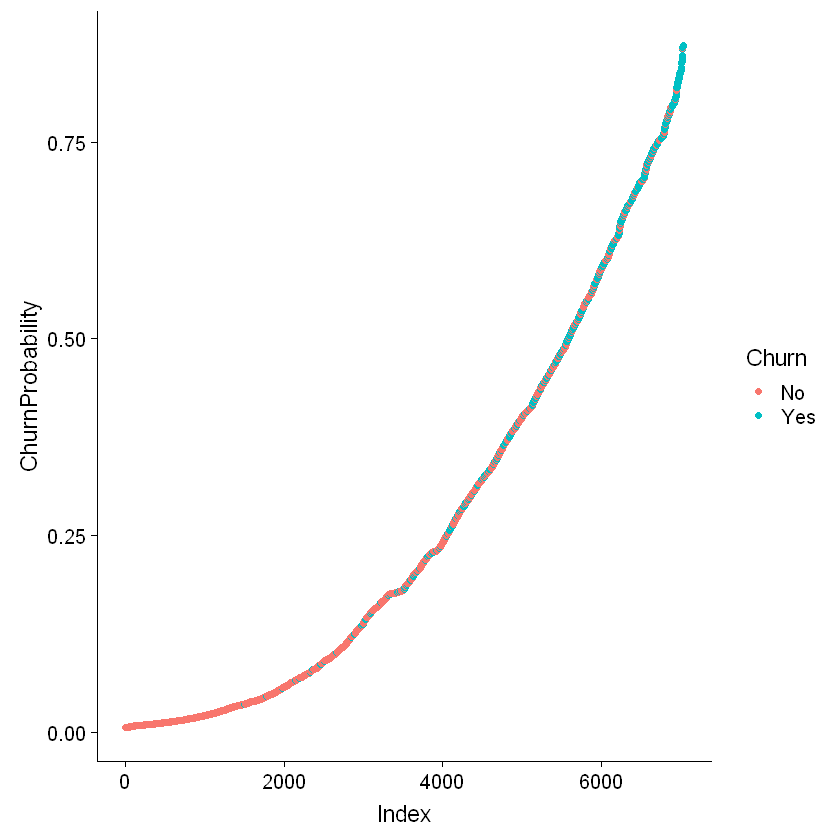

In [198]:
#Plotting data
predicted_data <- data.frame(ChurnProbability= logistiX$fitted.values, Churn=customer_data$Churn)
predicted_data <- predicted_data[order(predicted_data$ChurnProbability, decreasing=FALSE),]
predicted_data$rank <- 1:nrow(predicted_data)
ggplot(data=predicted_data, aes(x= rank, y=ChurnProbability))+geom_point(aes(color=Churn))+xlab("Index")
ggsave("C:/GitBird Projects/BellCoCustomerChurn/Churn Probability.jpg")

Churn probability prediction is given in as curve plot ranging from 0 to 1. The color prediction helps user take a quick glance for error margin. Since probability is continuous variable between 0 and 1 and does not have linear relationship with index, we can use ggplot and not bar plot or pie chart.

Above is graph of prediction. In the cluster, we can see:
- Most clients who churned are predicted to have high probability of churning <font color=turquoise>(Turquoise)</font>
- Most clients who did not churn are predicted to have low probablity of churning <font color=salmon>(Salmon Pink)</font>

Hence, we visually can see that there were very few clients who were predicted to be churned but did not and vice versa.

## Random Forest

Random forest is helpful in gathering important variables (numeric or categorical) for classification. It generates estimate of error as model building progresses and can handle large amount of data. 

In [154]:
#Random Forest Model
rfModel<- randomForest(Churn ~., data = customer_data)
rfModel



Call:
 randomForest(formula = Churn ~ ., data = customer_data) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 4

        OOB estimate of  error rate: 21.57%
Confusion matrix:
      No Yes class.error
No  4603 560   0.1084641
Yes  957 912   0.5120385

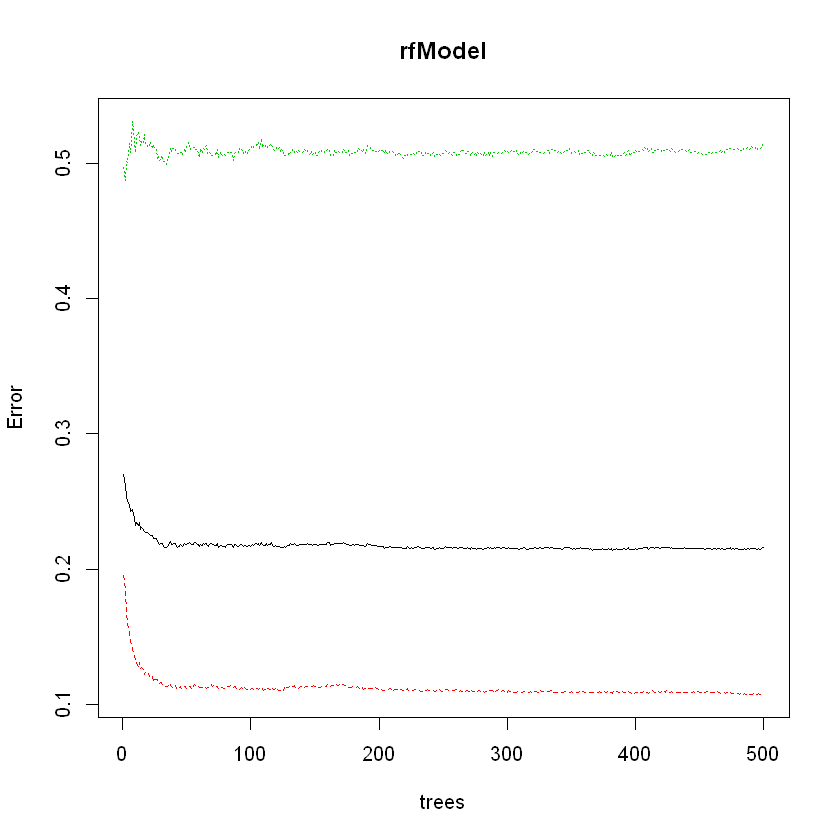

In [156]:
plot(rfModel)

Warning message in RColorBrewer::brewer.pal(nlevs, "Set1"):
"minimal value for n is 3, returning requested palette with 3 different levels
"

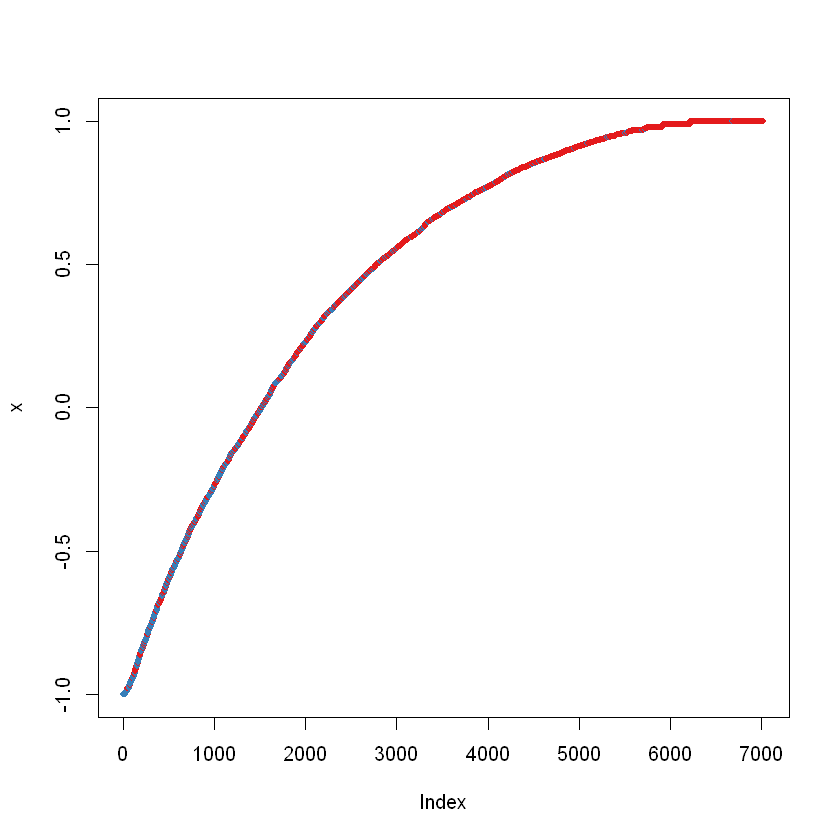

In [157]:
plot(margin(rfModel,customer_data$Churn))

In [70]:
#Prediction and Confusion matrix using train data
rfPredict_train <- predict(rfModel, train)
confusionMatrix(rfPredict_train, train$Churn)

Confusion Matrix and Statistics

          Reference
Prediction   No  Yes
       No  4000  170
       Yes  151 1301
                                          
               Accuracy : 0.9429          
                 95% CI : (0.9365, 0.9488)
    No Information Rate : 0.7383          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.8516          
 Mcnemar's Test P-Value : 0.3151          
                                          
            Sensitivity : 0.9636          
            Specificity : 0.8844          
         Pos Pred Value : 0.9592          
         Neg Pred Value : 0.8960          
             Prevalence : 0.7383          
         Detection Rate : 0.7115          
   Detection Prevalence : 0.7417          
      Balanced Accuracy : 0.9240          
                                          
       'Positive' Class : No              
                                          

In [71]:
#Misclassification with train data
tab_rf_train <- table(Predicted = rfPredict_train, Actual = train$Churn)
tab_rf_train
1 - sum(diag(tab_rf_train))/sum(tab_rf_train)

         Actual
Predicted   No  Yes
      No  4000  170
      Yes  151 1301

[1] 0.05709712

In [72]:
#Prediction and Confusion matrix using test data
rfPredict_test <- predict(rfModel, test)
confusionMatrix(rfPredict_test, test$Churn)

Confusion Matrix and Statistics

          Reference
Prediction  No Yes
       No  974  43
       Yes  38 355
                                          
               Accuracy : 0.9426          
                 95% CI : (0.9291, 0.9541)
    No Information Rate : 0.7177          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.8577          
 Mcnemar's Test P-Value : 0.6567          
                                          
            Sensitivity : 0.9625          
            Specificity : 0.8920          
         Pos Pred Value : 0.9577          
         Neg Pred Value : 0.9033          
             Prevalence : 0.7177          
         Detection Rate : 0.6908          
   Detection Prevalence : 0.7213          
      Balanced Accuracy : 0.9272          
                                          
       'Positive' Class : No              
                                          

In [73]:
#Misclassification error with test data:
tab_rf_test <- table(Predicted = rfPredict_test, Actual = test$Churn)
tab_rf_test
1 - sum(diag(tab_rf_test))/sum(tab_rf_test)

         Actual
Predicted  No Yes
      No  974  43
      Yes  38 355

[1] 0.05744681

Misclassification error when using random forest model is only 5.75%. Hence data was not discriminating in that light.

mtry = 4  OOB error = 20.95% 
Searching left ...
mtry = 8 	OOB error = 22.11% 
-0.05517827 0.05 
Searching right ...
mtry = 2 	OOB error = 19.96% 
0.0475382 0.05 


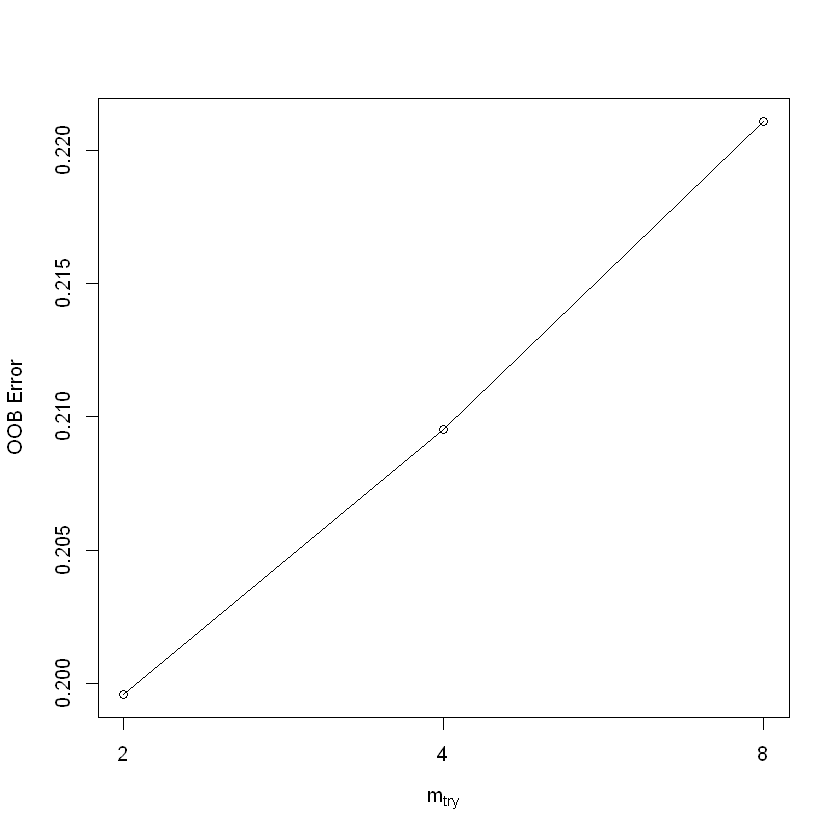

In [159]:
rfTune<-tuneRF(train[,-18], train[,18],
       stepFactor = 0.5, plot= TRUE,
       ntreeTry = 300, trace=TRUE, improve = 0.05)

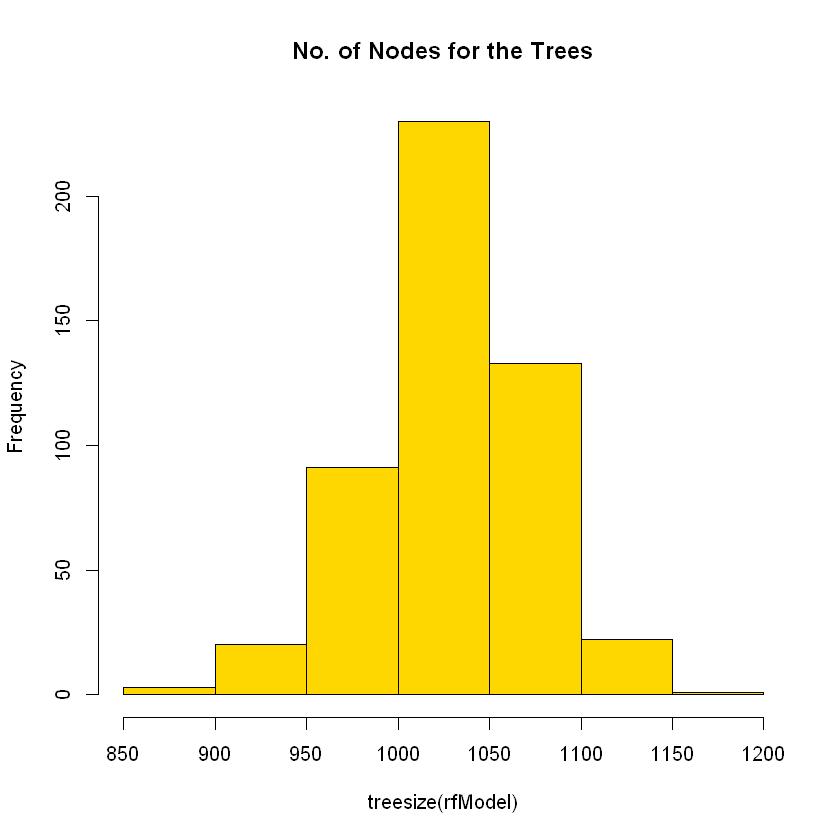

In [199]:
# No. of nodes for the trees
hist(treesize(rfModel), main = "No. of Nodes for the Trees", col = "gold")

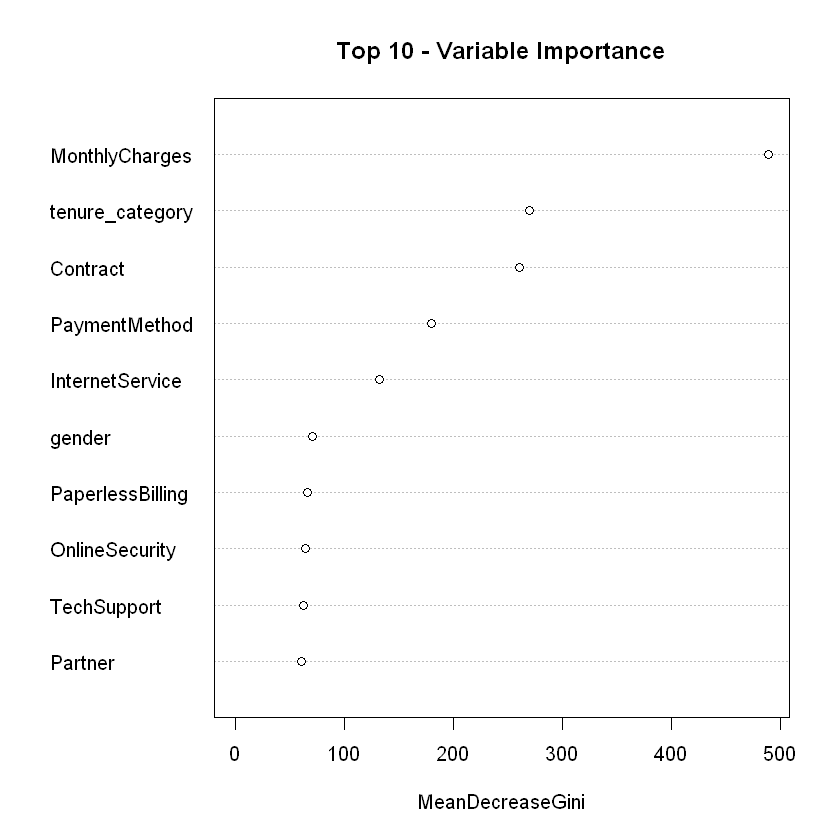

In [75]:
# Most important predictor variables
varImpPlot(rfModel, sort = T,n.var = 10, main = "Top 10 - Variable Importance")

## Decision Tree
Decision Tree is helpful in creating visual breakdown of major variables that influence churning and significant probability of churning. That way each node can be tracked and calculated on why people are churning.



	 Conditional inference tree with 10 terminal nodes

Response:  Churn 
Inputs:  Contract, PaperlessBilling, tenure_category 
Number of observations:  5622 

1) Contract == {One year, Two year}; criterion = 1, statistic = 929.803
  2) Contract == {Two year}; criterion = 1, statistic = 60.965
    3) PaperlessBilling == {No}; criterion = 0.967, statistic = 6.453
      4)*  weights = 716 
    3) PaperlessBilling == {Yes}
      5)*  weights = 645 
  2) Contract == {One year}
    6) PaperlessBilling == {No}; criterion = 1, statistic = 14.18
      7)*  weights = 535 
    6) PaperlessBilling == {Yes}
      8)*  weights = 645 
1) Contract == {Month-to-month}
  9) tenure_category == {1-2 years, 2-4 years, 4-5 years, Over 5 years }; criterion = 1, statistic = 125.396
    10) PaperlessBilling == {No}; criterion = 1, statistic = 34.259
      11)*  weights = 410 
    10) PaperlessBilling == {Yes}
      12) tenure_category == {2-4 years, 4-5 years, Over 5 years }; criterion = 1, statistic = 27.185
 

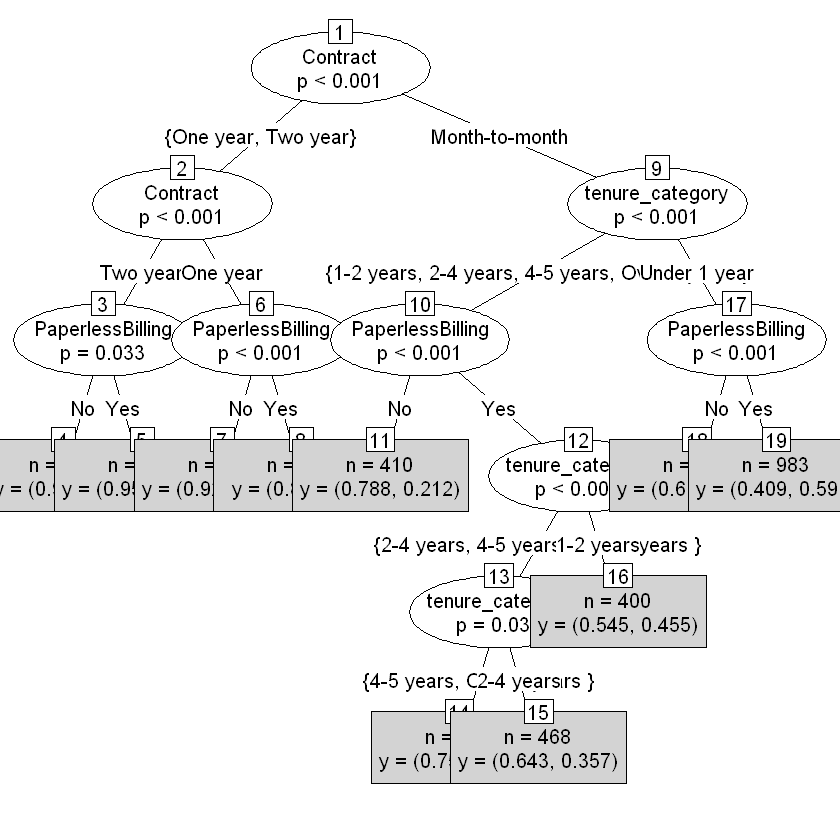

In [105]:
#Decision Tree
decision_tree <- ctree(Churn~Contract+PaperlessBilling+tenure_category, train)
print(decision_tree)
plot(decision_tree, type='simple')

In [201]:
#training
pred_tree_train <- predict(decision_tree, train)
head(pred_tree_train)

[1] Yes No  Yes No  Yes No 
Levels: No Yes

In [200]:
#Misclassification error with train data
tab_tree_train<-table(Predicted = pred_tree_train, Actual = train$Churn)
tab_tree_train
1-sum(diag(tab_tree_train))/sum(tab_tree_train)

         Actual
Predicted   No  Yes
      No  3749  890
      Yes  402  581

[1] 0.2298115

Misclassification error for Decision tree with training data is ~23%

In [84]:
#testing
pred_tree_test <- predict(decision_tree, test)
tab_tree_test <- table(Predicted = pred_tree_test, Actual = test$Churn)
print(paste('Decision Tree Accuracy:    ',sum(diag(tab2))/sum(tab2)))

[1] "Decision Tree Accuracy:     0.787943262411347"


In [85]:
#Misclassification error with test data
tab_tree_test<-table(Predicted = pred_tree_test, Actual = test$Churn)
1-sum(diag(tab_tree_test))/sum(tab_tree_test)

[1] 0.2432624

Misclassification error for Decision tree with testing data is ~24%

## Summary

__Descriptive__
Large number of non-senior citizen churns. One who has phone service and who reached out to techsupport churns.

__Diagnostic__
Few factors that affect churning are: Monthly Charges, Tenure Category, Contract and Payment Method

__Predictive__
Misclassification error with logistic model: 19-25%
Misclassification error with random forest model: ~5%
Misclassification error with decision tree model: 22-24%

__Prescriptive__
I would suggest the company to find customers who are on month to month contract, with less than 1-year tenure who had called TechSupport for any reason. They could be the one who are leaving more. I would know further reasons case by case basis and probably decrease their monthly charges as an incentive to stay in the service.

<font size=1.5>__References__:
				
- https://www.statmethods.net/management/variables.html
	 Robert I. Kabacoff, Ph.D.
	Quick-R powered by DataCamp
- https://www.dummies.com/programming/r/the-benefits-of-using-r/
	Andrie de Vries, Joris Meys
	Dummies, a wiley brand
- https://www.statisticshowto.datasciencecentral.com/univariate/
	Stephanie Glen		StatisticsHowTo
- https://www.statisticshowto.datasciencecentral.com/bivariate-analysis/
	Stephanie Glen		StatisticsHowTo </font>
